In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append('../')
import sqlite3
import json
from backtester import *
from fxcmtoken import major_forex_pairs

In [3]:
def get_data(ticker, freq, high_param, train_length=120, test_size=0.012):
    conn = sqlite3.connect(f'../PriceData/PriceData_{freq}.db')
    data = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
    conn.close()
    columns = ['open', 'high', 'low', 'close']
    for col in columns:
        data[col] = data[['bid'+col, 'ask'+col]].mean(axis=1)
#     train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)
    split_len = int(len(data) * test_size)
    test_len = split_len + high_param
    test_data = data[-test_len:]
    train_data = data[-(train_length+split_len+high_param):-split_len]
    
    return train_data, test_data

In [4]:
def get_signals(ticker, data, param_dict):
    params = param_dict['ThreeInds'][ticker]
    # get indicators
    ema_window = params[0]
    rsi_window = params[1]
    bb_window = params[2]
    
    data['ema'] = talib.EMA(data.close, ema_window)
    data['rsi'] = talib.RSI(data.close, rsi_window)
    data['bb_upper'], data['bb_mid'], data['bb_lower'] = talib.BBANDS(data.close, bb_window)
    data.dropna(axis=0, inplace=True)

    data['ema_signal'] = np.where(data.close > data.ema, 1, -1)
    
    data['rsi_signal'] = np.where(data.rsi > 70, -1, 
                                  np.where(data.rsi < 30, 1, np.nan))
    data['rsi_less_50'] = np.where(data.rsi < 50, 1, -1)
    data['rsi_signal'][(data.rsi_less_50 * data.rsi_less_50.shift(1) < 0)] = 0
    data.rsi_signal.ffill(inplace=True)
    data.rsi_signal.fillna(0, inplace=True)
    
    data['bb_signal'] = np.where(data.close > data.bb_upper, -1, 
                                 np.where(data.close < data.bb_lower, 1, np.nan))
    data['bb_less_mid'] = np.where(data.close < data.bb_mid, 1, -1)
    data['bb_less_mid'][(data.bb_less_mid * data.bb_less_mid.shift(1) < 0)] = 0
    data.bb_signal.ffill(inplace=True)
    data.bb_signal.fillna(0, inplace=True)
    
    signal_cols = ['ema_signal', 'rsi_signal', 'bb_signal']
    signals = data.loc[:,signal_cols].mode(axis=1).iloc[:, 0]
    
    return signals

In [5]:
freq = 'H1'
ticker = major_forex_pairs[0]
fname = f'../ta_optimize/json/OPTIMIZE_params_{freq}_500_20.json'
param_max = int(fname.split('_')[-2])
param_step = int(fname.split('_')[-1].split('.')[0])
print(freq, param_max, param_step)

with open(fname, 'r') as f:
    parameters = json.load(f)
parameters

H1 500 20


{'ThreeInds': {'AUD/USD': [300, 20, 80],
  'EUR/USD': [260, 52, 260],
  'GBP/USD': [200, 72, 40],
  'NZD/USD': [40, 28, 20],
  'USD/CAD': [280, 8, 380],
  'USD/CHF': [160, 8, 400],
  'USD/JPY': [40, 12, 60]}}

In [6]:
train_rets = []
test_rets = []

for ticker in tqdm(major_forex_pairs, leave=False):
    train, test = get_data(ticker, freq, max(parameters['ThreeInds'][ticker]))
    train_signals = get_signals(ticker, train, parameters)
    test_signals = get_signals(ticker, test, parameters)
    
    train_backtester = IterativeBacktester(data=train, freq=freq, signals=train_signals)
    train_backtester.backtest(progress_bar=False)
    train_ret = train_backtester.return_df.loc['TotalReturn', 'Portfolio']
    train_rets.append(train_ret)
    
    test_backtester = IterativeBacktester(data=test, freq=freq, signals=test_signals)
    test_backtester.backtest(progress_bar=False)
    test_ret = test_backtester.return_df.loc['TotalReturn', 'Portfolio']
    test_rets.append(test_ret)
    
print(freq, param_max, param_step)
print('***** Returns *****')
for ticker, train_ret, test_ret in zip(major_forex_pairs, train_rets, test_rets):
    print(f"{ticker} | Train: {train_ret*100:.2f}% | Test: {test_ret*100:.2f}%")
print('-'*50)
print(f"Total | Train: {np.mean(train_rets)*100:.2f}% | Test: {np.mean(test_rets)*100:.2f}%")

H1 500 20
***** Returns *****
EUR/USD | Train: 4.35% | Test: 1.51%
GBP/USD | Train: 2.02% | Test: 1.25%
USD/JPY | Train: 2.49% | Test: 0.13%
USD/CHF | Train: 1.69% | Test: -1.40%
USD/CAD | Train: 0.90% | Test: -0.52%
AUD/USD | Train: 4.32% | Test: 0.75%
NZD/USD | Train: 5.00% | Test: -1.07%
--------------------------------------------------
Total | Train: 2.96% | Test: 0.09%


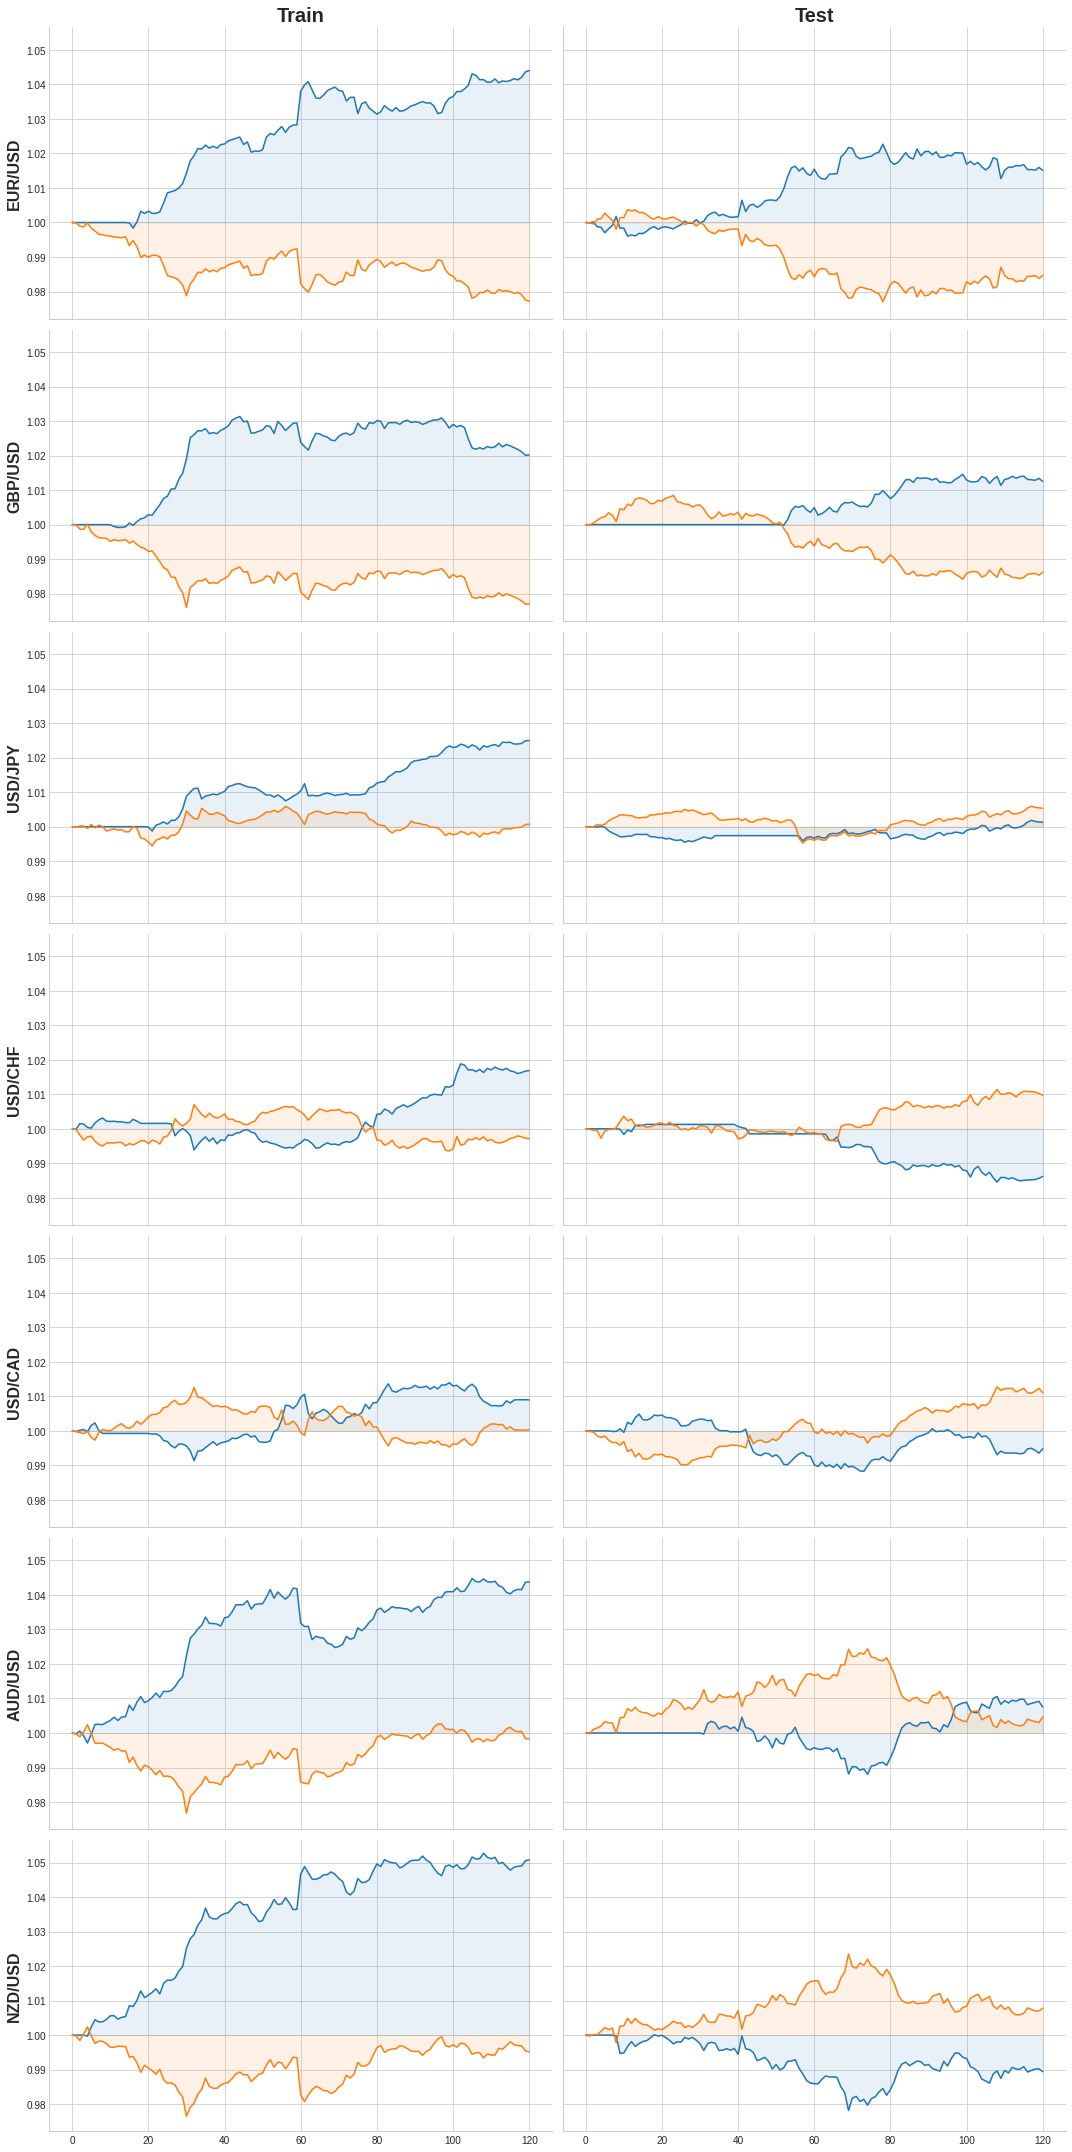

In [7]:
fig, ax = plt.subplots(len(major_forex_pairs), 2, figsize=(15, 30), sharex=True, sharey=True)

for i, ticker in tqdm(enumerate(major_forex_pairs), total=len(major_forex_pairs), leave=False):
    train, test = get_data(ticker, freq, max(parameters['ThreeInds'][ticker]))
    for j, price_data in enumerate([train, test]):
        signals = get_signals(ticker, price_data, parameters)
        backtester = IterativeBacktester(data=price_data, freq=freq, signals=signals)
        backtester.backtest(progress_bar=False ,leave=False)
        len_df = len(backtester.portfolio_df)
        port_val = backtester.portfolio_df.Portfolio.values
        bench_val = backtester.portfolio_df.Benchmark.values
        ax[i,j].plot(range(len_df), port_val, color='tab:blue')
        ax[i,j].plot(range(len_df), bench_val, color='tab:orange')
        ax[i,j].fill_between(x=range(len_df), y1=port_val, y2=port_val[0], color='tab:blue', alpha=0.1)
        ax[i,j].fill_between(x=range(len_df), y1=bench_val, y2=bench_val[0],color='tab:orange', alpha=0.1)
        if j == 0:
            ax[i,j].set_ylabel(f"{ticker}", fontsize=16, fontweight='bold')
        ax[i,j].set_xlabel('')
        if i == 0:
            if j == 0: 
                title = 'Train'
            else: 
                title = 'Test'
            ax[i, j].set_title(title, fontsize=20, fontweight='bold')
        sns.despine()
plt.tight_layout()
plt.show()